In [1]:
from IPython import display
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import math
import time

# The Generalized Algorithm

**1 -** Solve for $\rho$ (charge density) via $\rho = \sum_\alpha n_\alpha \, q_\alpha$

<br>

**2 -** Solve for $\phi$ (electric potential) via solving $ \, \triangledown^2 \phi = - \frac{e^2}{\epsilon_0 \epsilon_r} \, \rho $

<br>

**3 -** For each $\alpha$ do:


&emsp;&emsp; **a )** $\mu_\alpha = \bar{\mu}_\alpha + q_\alpha \, \phi$

<br>

&emsp;&emsp; **b )** $v_\alpha = \frac{1}{a} D_\alpha$

<br>

&emsp;&emsp; **c )** Create the `J_alpha_UMat` via the cellular update framework implemented to replace the $J_\alpha$ and the $\frac{\partial}{\partial t} n_\alpha$ calculations

<br>

&emsp;&emsp; **d )** Take the $n_\alpha$ time_step via $n_\alpha^{k+1} = n_\alpha^k + \frac{\Delta t}{a}$ `J_alpha_UMat`

<br>



# The Algorithm, Phase added

**1 -** Solve for $\rho$ (charge density) via $\rho = \sum_\alpha n_\alpha \, q_\alpha$

<br>

**2 -** Solve for $\phi$ (electric potential) via solving $\nabla E = \frac{e^2}{\epsilon_0} \, \rho$ and $\nabla \phi = - \frac{E}{\epsilon_r}$ by substitution: 

&emsp;&emsp; $ \nabla^2 \phi = - \frac{1}{\epsilon_r} \nabla E \implies \nabla^2 \phi = - \frac{e^2}{\epsilon_0 \epsilon_r} \, \rho $

<br>

**3 -** For each $\alpha$ do:

&emsp;&emsp; **a )** Let $\bar{\mu}_\alpha^S \equiv \bar{\mu}_\alpha(\theta = 0)$ and $\bar{\mu}_\alpha^L \equiv \bar{\mu}_\alpha(\theta = 1)$. For $A_\alpha \in \mathbb{R}, \, f(\theta) := \theta^2 \, (1 - \theta)^2, \, h(\theta) := 3 \theta^2 - 2 \theta^3 = \theta^2 (3 - 2 \theta) $, the update becomes:  

&emsp;&emsp;&emsp;&emsp; $\bar{\mu}_\alpha = \bar{\mu}_\alpha^S + \left(\bar{\mu}_\alpha^L - \bar{\mu}_\alpha^S \right) h(\theta) + \frac{1}{2} A_\alpha \, f(\theta) + \frac{1}{2} \epsilon^2 |\nabla \theta|^2 $

<br>

&emsp;&emsp; **b )** Take the $\theta$ time-step via 

&emsp;&emsp;&emsp;&emsp;$\frac{\partial}{\partial t} \theta \approx M V_{cell} \sum_\alpha n_\alpha \left[ \left(\bar{\mu}_\alpha^L - \bar{\mu}_\alpha^S \right) \frac{\partial}{\partial \theta} h(\theta) - A_\alpha \frac{\partial}{\partial \theta} f(\theta) + \epsilon^2 \nabla^2 \theta \right] $  

&emsp;&emsp;&emsp;&emsp; $\theta^{k+1} = \theta^{k} + \Delta t \left( \frac{\partial}{\partial t} \theta \right)^k $ 

&emsp;&emsp;&emsp;&emsp; where $\frac{\partial}{\partial \theta} f(\theta) := 2 \theta (1 - \theta) (1 - 2 \theta)$ and $\frac{\partial}{\partial \theta} h(\theta) := 6 \theta (1 - \theta) $



<br>


&emsp;&emsp; **c )** $\mu_\alpha = \bar{\mu}_\alpha + q_\alpha \, \phi$

<br>

&emsp;&emsp; **d )** $v_\alpha = \frac{1}{a} D_\alpha$

<br>

&emsp;&emsp; **e )** Create the `J_alpha_UMat` via the cellular update framework implemented to streamline and replace the $J_\alpha$ and the $\frac{\partial}{\partial t} n_\alpha$ calculations

<br>

&emsp;&emsp; **f )** Take the $n_\alpha$ time-step via $n_\alpha^{k+1} = n_\alpha^k + \frac{\Delta t}{a}$ `J_alpha_UMat`


<br>



# NOTES

### Implement Rectangular Domain Compatibility
- Check all indexing 
- Check the Laplace/Poisson matrix construction

<br>

### .flatten() & .reshape( ... ) for $\theta$ and other variables

###

In [2]:
def laplace_matrix_2D_RD(Nx, Ny):
    """
    Creates the 2D Laplacian discretization matrix for a rectangular domain,
        thereby allowing for cases where Nx =/= Ny 
    Input: Nx & Ny (int), number of grid points on x- & y-axes
    Output: A_matrix (float array), 2D Laplacian discretization matrix
    """
    # initialize the Laplacian discretization matrix
    A_matrix = np.zeros((Nx*Ny, Nx*Ny))
    
    # iterate over the main diagonal
    for i in range(Nx*Ny):
        
        A_matrix[i][i] = -4 # coefficient for current cell x_i,j 
        
        if (i > 0):
            A_matrix[i-1][i] = 1 # coefficient for right neighbor x_i+1,j 
            
            if (((i + 1) % Ny == 1) and (i < Nx * Ny - 1)):
                A_matrix[i-1][i] = 0 # remove non-existent right neighbor x_i+1,j 
                                        # when reaching the end of a row       
        if (i < Nx * Ny) and (i > 0):
            A_matrix[i][i-1] = 1 # coefficient for left neighbor x_i-1,j 
            
        if (((i + 1) % Ny == 1) and (i > 2)):
            A_matrix[i][i-1] = 0 # remove non-existent left neighbor x_i-1,j 
                                        # when reaching the end of a row
                
    # np.diag() to add coefficients for top (x_i,j-1) and bottom (x_i,j+1) neighbors respectively       
    A_matrix += np.diag(np.ones(Nx * Ny - Ny), -Ny) + np.diag(np.ones(Nx * Ny - Ny), Ny)
  
    return A_matrix


*Changes :* Rename the function `laplace_matrix_2D_RD()` as it seems to be more appropriate/logical 

***Step 1 :*** $\rho$ Update

In [3]:
def rho_update_2D(n_alpha, q_alpha):
    """
    Updates / computes rho^k (rho at the current time-step)
    Input: n_alpha (float array), (alpha) x (Nx) x (Ny) array storing current n_alpha
               grid values for each respective species alpha
           q_alpha (int array), each entry represents charge of a species
    Output: rho (float array), (Nx) x (Ny) charge density array
    """
    # initialize rho to Nx x Ny size, bypass the 1st array dimension
    rho = np.zeros(np.shape(n_alpha)[1:]) 
    
    # iterate over the alphas
    for i in range(np.shape(n_alpha)[0]):
        
        rho += n_alpha[i] * q_alpha[i] # update / compute rho
        
    return rho # return 2D rho array

*Changes :* The `Na` input was removed. Not necessary as `rho` is initialized via the shape of the `n_alpha` input.

***Step 2 :*** $\phi$ Update

In [4]:
def phi_update_2D(a, Nx, Ny, A_matrix, rho, epsilon_0, epsilon_r): 
    """
    Updates / computes phi^k (phi at the current time-step) via
        solving Poisson's equation
    Input: a (float), a = dx = dy
           Nx & Ny (int), number of grid points on x- & y-axes
           A_matrix (float array), 2D Laplacian discretization matrix
           rho (float array), (Nx) x (Ny) charge density array
           epsilon_0 & epsilon_r (float), constants
    Output: phi (float array), (Nx) x (Ny) electric potential array
    """
    
    c_rho = a**2 * np.exp(1)**2 / (2.0 * epsilon_0 * epsilon_r) # store the constant for the RHS vector

    rho_vec = rho.flatten() # from 2D to 1D
    
    # use GMRES to solve for phi^k (until you explore solver efficiency!!!!)
    phi = scipy.sparse.linalg.gmres(-A_matrix, c_rho * rho_vec)[0]
    
    return phi.reshape((Nx, Ny)) # return 2D phi array


*Changes :* `ghosts_included = True` input removed since the Poisson discretization matrix we are using assumes that the ghost cells lying outside of the computational domain have Dirichlet BCs (of 0s). Therefore also removed the removal and addition of ghost cells within the computational domain.

`Na` input changed to `Nx, Ny` to allow for rectangular domains. 

***Step 3 - a :*** $\bar{\mu}_\alpha$ Update



In [178]:
def gradient_finder_2D(func):
    """
    Finds the d/dx and d/dy gradient fields of a 2D function/matrix
    NOTE : Identical to what numpy.gradient() does, however serves as
        a proof of concept for the C++ implementation
    NOTE : numpy.hstack() & .vstack() used for convenience, would be 
        replaced by simple loops in C++
    Inputs: func (float array), (Nx) x (Ny) array with entries representing function
        values for which d/dx and d/dy will be calculated
    Output: dx_func & dy_func (float array), (Nx) x (Ny) dfunc/dx & dfunc/dy arrays    
    """
    # calculate the x-derivative
        # cells in the middle have the average of the left- and right- derivatives
    x_difference = func[:, 1:]  - func[:, :-1] # defined as x_i+1,j - x_i,j
    dx_func = np.hstack((np.transpose(np.array([x_difference[:,0]])), 0.5 * (x_difference[:,1:] + x_difference[:,:-1]), np.transpose(np.array([x_difference[:,-1]]))))
    
    # calculate the y-derivative
        # cells in the middle have the average of the down- and up- derivatives
    y_difference = func[1:, :]  - func[:-1, :] # defined as x_i,j+1 - x_i,j
    dy_func = np.vstack(((np.array([y_difference[0,:]])), 0.5 * (y_difference[1:,:] + y_difference[:-1,:]), (np.array([y_difference[-1,:]]))))
    
    return dx_func, dy_func # return 2D dfunc/dx & dfunc/dy arrays   


def mu_bar_alpha_update_2D(a, Nx, Ny, theta, mu_bar_alpha_0, mu_bar_alpha_1, A_alpha, epsilon): 
    """
    Updates / computes mu_bar_alpha^k (mu_bar_alpha at the current time-step)
    Input: a (float), a = dx = dy
           Nx & Ny (int), number of grid points on x- & y-axes
           theta (float array), (Nx * Ny) array representing the flattened 2D phase
           mu_bar_alpha_0 & mu_bar_alpha_1 (float array), (alpha) x (Nx * Ny) mu_bar_alpha
               chemical potential arrays for the purely solid and liquid phases respectively
           A_alpha (float array), each entry represents a constant for a species
           epsilon (float), a constant scaling theta's gradient contribution 
    Output: mu_bar_alpha (float array), (alpha) x (Nx) x (Ny) electrochemical potential array
    """
    mu_bar_alpha = np.zeros(np.shape(mu_bar_alpha_0)) # initialize mu_bar_alpha as a 2D alpha x Nx*Ny array
    
    # store the f(theta) expression
    f_theta = theta**2 * (1 - theta)**2
    
    # store the h(theta) expression
    h_theta = theta**2 * (3 - 2 * theta)
   
    # store the gradient of theta expression (independent of alpha)
                        #dthet_dx, dthet_dy = np.gradient(0.5 * epsilon**2 * theta.reshape([Nx, Ny]))
    dtheta_dx, dtheta_dy = gradient_finder_2D(0.5 * epsilon**2 * theta.reshape([Nx, Ny]))
    
    for i in range(np.shape(mu_bar_alpha_0)[0]): # iterate over the alphas
        
        # update / compute mu_bar_alpha
        mu_bar_alpha[i] = mu_bar_alpha_0[i] + (mu_bar_alpha_1[i] - mu_bar_alpha_0[i]) * h_theta - 0.5 * A_alpha[i] * f_theta + 0.5 * epsilon**2 * (dtheta_dx.flatten()**2 + dtheta_dy.flatten()**2) 
        
    return mu_bar_alpha.reshape((np.shape(mu_bar_alpha_0)[0], Nx, Ny)) # return as a 3D alpha x Nx x Ny array
                                                                        # for easier use in mu_alpha_update()
    

**Note :** When writing the 3D code, check the to-be-written `gradient_finder_3D()` vs `np.gradient()` !!! 

***Step 3 - b :*** $\theta$ Update / Time-Step

&emsp;&emsp;&emsp;&emsp;$\frac{\partial}{\partial t} \theta \approx M V_{cell} \sum_\alpha n_\alpha \left[ \left(\bar{\mu}_\alpha^L - \bar{\mu}_\alpha^S \right) \frac{\partial}{\partial \theta} h(\theta) - A_\alpha \frac{\partial}{\partial \theta} f(\theta) + \epsilon^2 \nabla^2 \theta \right] $  

&emsp;&emsp;&emsp;&emsp; $\theta^{k+1} = \theta^{k} + \Delta t \left( \frac{\partial}{\partial t} \theta \right)^k $ 

&emsp;&emsp;&emsp;&emsp; where $\frac{\partial}{\partial \theta} f(\theta) := 2 \theta (1 - \theta) (1 - 2 \theta)$ and $\frac{\partial}{\partial \theta} h(\theta) := 6 \theta (1 - \theta) $





# some STUFF regarding BCs for $\theta$'s Laplacian

In [388]:
def theta_update_2D(dt, a, Nx, Ny, n_alpha, theta, A_matrix, A_alpha, mu_bar_alpha_0, mu_bar_alpha_1, M, epsilon):
    """
    Updates / computes theta^(k+1) (theta at the future time-step) via 
        forward in time discretization
    Input: dt (float), size of time-step, dt
           a (float), a = dx = dy
           Nx & Ny (int), number of grid points on x- & y-axes
           n_alpha (float array), (alpha) x (Nx) x (Ny) array storing current n_alpha
               grid values for each respective species alpha
           theta^k (float array), (Nx * Ny) array representing the flattened 2D phase
           A_matrix (float array), 2D Laplacian discretization matrix
           A_alpha (float array), each entry represents a constant for a species
           mu_bar_alpha_0 & mu_bar_alpha_1 (float array), (alpha) x (Nx * Ny) mu_bar_alpha
               arrays for the purely solid and liquid phases respectively
           M (float), a constant 
           epsilon (float), a constant scaling theta's Laplacian contribution 
    Output: theta^(k+1) (float array), (Nx * Ny) array representing the flattened 2D phase
    """
    # initialize dtheta/dt
    dtheta_dt = np.zeros(np.shape(theta))
    
    # calculate & store h'(theta) and f'(theta)
    df_dt = theta * (1 - theta) * (1 - 2 * theta)
    dh_dt = 6 * theta * (1 - theta)
    
    # save the result of the matrix-vector product 
    A_theta = A_matrix @ theta
    A_theta = np.pad((A_theta.reshape([Nx,Ny])[1:-1,1:-1]), 1)
    
    # Neumann BCs for edges
    for i in range(1,Nx):
        A_theta[i,0] = A_theta[i,1]       # left BC
        A_theta[i,Nx-1] = A_theta[i,Nx-2] # right BC
    for i in range(1,Ny):
        A_theta[0,i] = A_theta[1,i]       # top BC
        A_theta[Ny-1,i] = A_theta[Ny-2,i] # bottom BC
    A_theta[0,0] = 0.5 * (A_theta[0,1] + A_theta[1,0])                   # top left BC
    A_theta[0,Nx-1] = 0.5 * (A_theta[0,Nx-2] + A_theta[1,Nx-1])          # top right BC
    A_theta[Ny-1,0] = 0.5 * (A_theta[Ny-1,1] + A_theta[Ny-2,0])          # bottom left BC
    A_theta[Ny-1,Nx-1] = 0.5 * (A_theta[Ny-1,Nx-2] + A_theta[Ny-2,Nx-1]) # top left BC
    
    # from 2D to 1D storage
    A_theta = A_theta.flatten() 
        
    # sum over the alphas
    for i in range(np.shape(mu_bar_alpha_0)[0]):
        
        dtheta_dt += n_alpha[i].flatten() * ((mu_bar_alpha_1[i] - mu_bar_alpha_0[i]) * dh_dt - A_alpha[i] * df_dt + epsilon**2 * A_theta)
        
    # take a theta time-step
    theta += dt * M * dtheta_dt
    
    return theta

***Step 3 - c & d :*** ${\mu}_\alpha \& v_\alpha$ Update

In [25]:
def mu_and_v_alpha_update_2D(a, mu_bar_alpha, q_alpha, phi, D_alpha):
    """
    Input: a (float), a = dx = dy
           mu_bar_alpha (float array), (alpha) x (Nx) x (Ny) chemical potential array
           q_alpha (int array), each entry represents charge of a species
           phi (float array), (Nx) x (Ny) electric potential array
           D_alpha (float array), (alpha) x (Nx) x (Ny) diffusion coefficient array
    Output: mu_alpha (float array), (alpha) x (Nx) x (Ny) electrochemical potential array
            v_alpha (float array), (alpha) x (Nx) x (Ny) velocity array
    """
    # initialize mu_alpha
    mu_alpha = np.zeros(np.shape(mu_bar_alpha))

    # initialize v_alpha
    v_alpha = np.zeros(np.shape(mu_bar_alpha))
    
    for i in range(len(q_alpha)): # loop over 1st dimension (layer) of 3D mu_alpha & v_alpha tensors
        
        mu_alpha[i] = mu_bar_alpha[i] + q_alpha[i] * phi  

        v_alpha[i] = (1.0/a) * D_alpha[i]
          
    return mu_alpha, v_alpha # both returned as 3D alpha x Na x Na arrays
     

*Changes :* Instead of input `Na` we will use `a`$\equiv dx = dy$. How will we define a, I do not know :D Possibly use something like $a = 1/max(Nx, Ny)$ ???????

***Step 3 - e :*** $J_\alpha$ "Update" via `J_alpha_UMat`

In [26]:
def J_alpha_update_2D(T, k_B, mu_alpha, v_alpha, n_alpha):
    """
    Computes the precursor to dn_alpha/dt, J_alpha_UMat
    Input: T (float), temperature
           k_B (float), Boltzmann's constant 
           mu_alpha (float array), (alpha) x (Nx) x (Ny) electrochemical potential array 
           v_alpha (float array), (alpha) x (Nx) x (Ny) velocity array
           n_alpha (float array), (alpha) x (Nx) x (Ny) array storing current n_alpha
               grid values for each respective species alpha
    Output: J_alpha_UMat (float array), (alpha) x (Nx) x (Ny) particle current update array
    """
    
    # initialize J_alpha_UMat to have m x (Na) x (Na) dimensions
    J_alpha_UMat = np.zeros((np.shape(n_alpha)[0], np.shape(n_alpha)[1], np.shape(n_alpha)[2]))
    # Our update matrix which we will simply scale and then add on n_alpha_Current !!! Pretty COOL !
    
    # Our axes : +-----> (x-axis)
    #            |
    #            |
    #            v (y-axis)
    # each cell n_alpha has 4 possible neighbors, left, right, top, bottom
        # all of these neighbors exchange information to form dn/dt
        # NOTE: some cells have 2 (corner) or 3 (edge) neighbors which needs to be accounted for
    
    # now iterate over each grid index, update J_alpha_UMat values for all alphas each iteration
    
    c = np.exp(-1) # just store as one value
    
    # 1st : Deal with the Interior (Na - 2) x (Na - 2) domain
    for i in range(1, np.shape(n_alpha)[1] - 1):
        for j in range(1, np.shape(n_alpha)[2] - 1):
            
            # signs given to be positive if flow into cell i,j
            J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
            J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
            J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
            J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
            
            J_alpha_UMat[:,i,j] = J_left + J_right + J_top + J_bottom
            
    
    # 2nd : Deal with the Edges
    for j in range(1, np.shape(n_alpha)[2] - 1):
        
        # left column
        i = 0
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_top + J_bottom + J_right # left column 
    
        # right column
        i = np.shape(n_alpha)[1] - 1
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_top + J_bottom + J_left # right column 
    
    for i in range(1, np.shape(n_alpha)[1] - 1):
    
        # top row
        j = 0
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_left + J_right + J_bottom
       
        # bottom row
        j = np.shape(n_alpha)[2] - 1
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_alpha_UMat[:,i,j] = J_left + J_right + J_top   
    
    # 3rd : Deal with the Corners
    
    # top left corner
    i = 0
    j = 0
    J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
    J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
    J_alpha_UMat[:,i,j] = J_bottom + J_right 
    
    # top right corner
    i = np.shape(n_alpha)[1] - 1
    j = 0
    J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
    J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
    J_alpha_UMat[:,i,j] = J_bottom + J_left
    
    # bottom left corner
    i = 0
    j = np.shape(n_alpha)[2] - 1
    J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
    J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1] 
    J_alpha_UMat[:,i,j] = J_top + J_right
    
    # bottom right corner
    i = np.shape(n_alpha)[1] - 1
    j = np.shape(n_alpha)[2] - 1
    J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
    J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
    J_alpha_UMat[:,i,j] = J_top + J_left
    
    return J_alpha_UMat


*Changes :* Removed `Na` from the inputs as no other variable is using it. 

***Step 3 - f :*** $n_\alpha$ Update / Time-Step

In [27]:
def n_alpha_update_Forward_2D(dt, a, n_alpha, J_alpha_UMat):
    """
    Updates / computes n_alpha^(k+1) (n_alpha at the future time-step) via 
        forward in time discretization
    Input: dt (float), size of time-step, dt
           a (float), a = dx = dy
           n_alpha (float array), (alpha) x (Nx) x (Ny) array storing current n_alpha
               grid values for each respective species alpha
           J_alpha_UMat (float array), (alpha) x (Nx) x (Ny) particle current update array
    Output: n_alpha^(k+1) (float array), (alpha) x (Nx) x (Ny) array storing updated n_alpha
               grid values for each respective species alpha
    """
    # take a time-step for n_alpha
    n_alpha += (dt / a) * J_alpha_UMat
    
    return n_alpha

*Changes :* Replaced input `Na` by `a`. Again a similar problem to the one mentioned in the comments for `mu_and_v_alpha_update_2D()` with what the exact definition of $a$ should be...

Removed the `B_x` creation because there was no need, why did I do that? Maybe for the Backward and Central temporal discretizations for the 1D n_alpha update fxns? 

<br>

**BIG Change :** removed all dependencies on `n_alpha_Update`, `n_alpha_Current`, and `n_alpha_Past` $\rightarrow$ `n_alpha`

***Iteration Function***

Changes to iteration will be significant!!!

- inputs like `Dx_matrix`, `Dy_matrix`, `phase`, and `mu_bar_alpha_0` 

In [28]:
def iteration_Forward_2D(dt, i_glob, a, Nx, Ny, T, k_B, A_matrix, q_alpha, theta, n_alpha, mu_bar_alpha_0, D_alpha, A_alpha, M, epsilon, epsilon_0 = 1, epsilon_r = 1):
    """
    Performs an iteration via forward in time discretization
    Input: dt (float), size of time-step, dt
           i_glob (int), global iteration counter (UNUSED VARIABLE)
           a (float), a = dx = dy
           Nx & Ny (int), number of grid points on x- & y-axes
           T (float), temperature
           k_B (float), Boltzmann's constant 
           A_matrix (float array), 2D Laplacian discretization matrix
           q_alpha (int array), each entry represents charge of a species
           theta (float array), (Nx * Ny) array representing the flattened 2D phase
           n_alpha (float array), (alpha) x (Nx) x (Ny) array storing current n_alpha
               grid values for each respective species alpha
           mu_bar_alpha_0 & mu_bar_alpha_1 (float array), (alpha) x (Nx * Ny) mu_bar_alpha
               chemical potential arrays for the purely solid and liquid phases respectively
           D_alpha (float array), (alpha) x (Nx) x (Ny) diffusion coefficient array
           A_alpha (float array), each entry represents a constant for a species
           M & epsilon & epsilon_0 & epsilon_r (float), constants
    Output: n_alpha^(k+1) (float array), (alpha) x (Nx) x (Ny) array storing updated n_alpha
               grid values for each respective species alpha
            theta^(k+1) (float array), (Nx * Ny) array representing the flattened 2D phase
            mu_alpha (float array), (alpha) x (Nx) x (Ny) electrochemical potential array
    """
    # update rho
    rho = rho_update_2D(n_alpha, q_alpha)
    
    # update phi
    phi = phi_update_2D(a, Nx, Ny, A_matrix, rho, epsilon_0, epsilon_r)
    
    # update mu_bar_alpha
    mu_bar_alpha = mu_bar_alpha_update_2D(a, Nx, Ny, theta, mu_bar_alpha_0, mu_bar_alpha_1, A_alpha, epsilon)
    
    # update theta (phase) - update after calculating mu_bar_alpha with the current theta
    theta = theta_update_2D(dt, a, Nx, Ny, n_alpha, theta, A_matrix, A_alpha, mu_bar_alpha_0, mu_bar_alpha_1, M, epsilon)
    
    # update mu_alpha & v_alpha, N O T E : combined mu_alpha_update_1D and v_alpha_update_1D into ONE function
    mu_alpha, v_alpha = mu_and_v_alpha_update_2D(a, mu_bar_alpha, q_alpha, phi, D_alpha)
    
    # update J_alpha
    J_alpha_UMat = J_alpha_update_2D(T, k_B, mu_alpha, v_alpha, n_alpha)
    
    # update n_alpha
    n_alpha = n_alpha_update_Forward_2D(dt, a, n_alpha, J_alpha_UMat)
   
    return n_alpha, theta, mu_alpha

*Changes :*

- Added inputs : `Dx_matrix`, `Dy_matrix`, `mu_bar_alpha_0`, `epsilon`, `A_alpha`, `theta`, `M`

- Changed inputs : `Na` $\rightarrow$ `Nx`&`Ny`&`a`,     !!! `n_alpha_Update`, `n_alpha_Current`, and `n_alpha_Past`$\rightarrow$ `n_alpha` !!!

- Inputs removed : `ghosts_included = True`

<br>

- Functions added : `mu_bar_alpha()`, `theta_update_2D()`

<br>

- Return added : `theta`

<br>

**BIG Change :** removed all dependencies on `n_alpha_Update`, `n_alpha_Current`, and `n_alpha_Past` $\rightarrow$ `n_alpha`

***Simulation Function***


Changes to simulation will be significant!!!

- create A_matrix, Dx_matrix, and Dy_matrix
- maybe some new variables needed as input, like `mu_bar_alpha_0` and the initial phase $\theta^{k=0} \equiv$`phase`. 

In [29]:
def simulation_Forward_2D(dt, tmax, Nx, Ny, T, k_B, theta, n_alpha, q_alpha, mu_bar_alpha_0, D_alpha, A_alpha, plotting = False, epsilon_r = 1, epsilon_0 = 1, epsilon = 1, M = 100000): # dt, Na, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1
    
    i_glob = 0 # global iteration counter (specifically for 1st timestep's n'(x, t) calculation)
    t_cur = 0.0  # global time counter
    
    a = 1.0/np.max((Nx,Ny)) # calculate dx
    
    A_x = np.arange(0, 1 + 1e-15, a)         # length of Na + 1
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na
    
    # initialize 
    n_plotting = np.array([])
    
    # construct the 2D Laplacian discretization matrix A
    A_matrix = laplace_matrix_2D_RD(Nx, Ny)
    
    # store theta as a 1D array, return as 2D array
    theta = theta.flatten()
    
    # start plotting/animating
    fig = plt.figure() # initialize figure
    axis = plt.axes(xlim =(0, 1), ylim =(-2, 10)) # marking the x-axis and y-axis 
    line, = axis.plot([], [], lw = 3) # initializing a line variable 
    plt.close() # to not have a stray plot
    
    # data which the line will 
    # contain (x, y) 
    def init(): 
        line.set_data([], []) 
        return line, 
    
    def animate(i): 
        x = np.arange(a/2, 1 - a/2 + 1e-15, a) # set the x axis to B_x

        if (i < int(tmax/dt - 1e-15)):
            
            n_plot = n_plot_matrix[i,:] # extract the i^th row for plotting
        
            line.set_data(x, n_plot) 
            
        else:
            
            return line,
      
        return line,
    
    
    while (t_cur < tmax):
        
        n_alpha, theta, mu_alpha = iteration_Forward_2D(dt, i_glob, a, Nx, Ny, T, k_B, A_matrix, q_alpha, theta, n_alpha, mu_bar_alpha_0, D_alpha, A_alpha, M, epsilon, epsilon_0 = 1, epsilon_r = 1)
        
        if (plotting):
            
            n_plotting = np.append(n_plotting, n_alpha)
                     
        i_glob += 1
        t_cur += dt
        
    if (plotting):
        
        n_plot_matrix = n_plotting.reshape((int(tmax/dt - 1e-15) + 1, len(B_x))) # every row corresponds to N_alpha 
                                                                 # at a different time-step  
        anim = FuncAnimation(fig, animate, init_func = init, frames = 500, interval = 20, blit = True)
        
        #return HTML(anim.to_jshtml())
        
        return anim
    
    else:
        
        print('\nSimulation completed at time', t_cur, '!!!')
        
        return n_alpha, theta.reshape((Nx, Ny)), mu_alpha, t_cur
    

# Melting Test

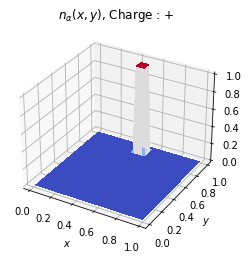

In [376]:
Na = 41
Nx = Na
Ny = Na
T = 300
k_B = 1e2
a = 1.0/Na
dt = 2 * a**2
t_max = 5000 * dt #2000
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([0, 0]) #np.array([25, -25])
A_alpha = np.array([1,1])
mu_bar_alpha_0 = 5 + np.zeros((2, Na * Na))  # different mu_bar values for the alphas
mu_bar_alpha_1 = 7 + np.zeros((2, Na * Na))  # different mu_bar values for the alphas
D_alpha = 1e-1 * np.ones((2, Na, Na))
                         
# Forward Euler temporal discretization
n_alpha = np.zeros((2, Na, Na))

n_CPFM_1D_forward = np.zeros((2, Na, Na))

X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

theta = 0.1 * np.sin(np.pi * xx) * np.sin(np.pi * yy) 


N_mid = int((Na-1)/2)
theta = np.zeros((Na, Na))
theta[:,:N_mid] = 1.0
theta[:,N_mid:N_mid+2] = 0.5

theta[:,:] = np.linspace(0,1,Na)

theta = np.zeros((Na, Na))
theta[:,:N_mid] = 0.0
#theta[:,N_mid:N_mid+4] = np.linspace(0.1,1,4)
theta[:,N_mid:] = 1.0

n_alpha[0, Nx-6:Nx-2, N_mid-2:N_mid+2] += 1.0
n_alpha[1, 2:6, N_mid-2:N_mid+2] += 1.0
n_CPFM_1D_forward[:,N_mid-2:N_mid+2, N_mid-2:N_mid+2] = 1.0

#theta = 0.5 * np.ones((Na, Na))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_alpha[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$n_\alpha(x,y)$, Charge : $+$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


In [377]:
n_CPFM_1D_forward, theta, mu_alpha, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Nx, Ny, T, k_B, theta, n_alpha, q_alpha, mu_bar_alpha_0, D_alpha, A_alpha, plotting = False, epsilon_r = 1, epsilon_0 = 1, epsilon = 1, M = 1) 



Simulation completed at time 5.950029744199541 !!!


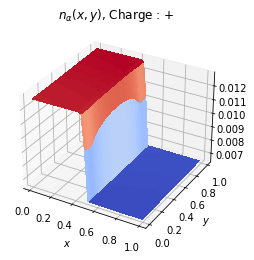

In [378]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_alpha[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$n_\alpha(x,y)$, Charge : $+$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()



In [379]:
X = x_ax
Y = x_ax
xx, yy = np.meshgrid(X, Y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_alpha[1], cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_title(r'$n_\alpha(x,y)$, Charge : $-$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

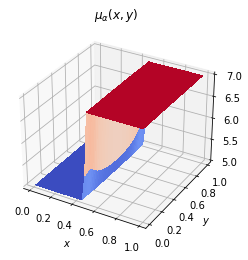

In [380]:
X = x_ax
Y = x_ax
xx, yy = np.meshgrid(X, Y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, mu_alpha[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\mu_\alpha(x,y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

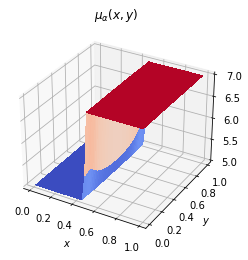

In [381]:
X = x_ax
Y = x_ax
xx, yy = np.meshgrid(X, Y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, mu_alpha[1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\mu_\alpha(x,y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [382]:
plt.plot(x_ax, mu_alpha[0,2])

In [383]:
np.min(mu_alpha[0,1])

5.0

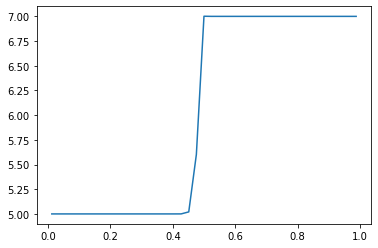

In [384]:
plt.plot(x_ax, mu_alpha[0,1])

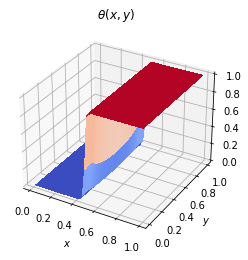

In [385]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

theta = theta.reshape((Na, Na))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, theta, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\theta(x,y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

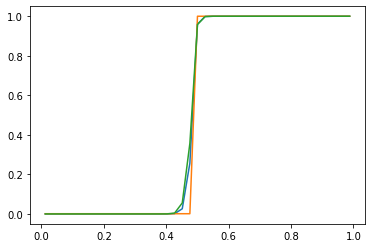

In [386]:
theta_0 = np.zeros(np.shape(theta[0]))
theta_0[:N_mid] = 0.001
#theta_0[N_mid:N_mid+4] = np.linspace(0.1,1,4)
theta_0[N_mid:] = 1.0

plt.plot(x_ax, theta[15], x_ax, theta_0, x_ax, theta[0])

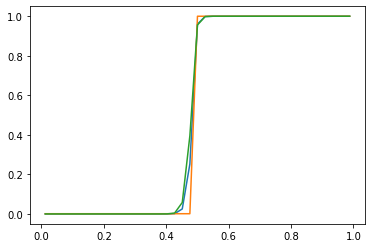

In [373]:
theta_0 = np.zeros(np.shape(theta[0]))
theta_0[:N_mid] = 0.001
#theta_0[N_mid:N_mid+4] = np.linspace(0.1,1,4)
theta_0[N_mid:] = 1.0

plt.plot(x_ax, theta[15], x_ax, theta_0, x_ax, theta[0])

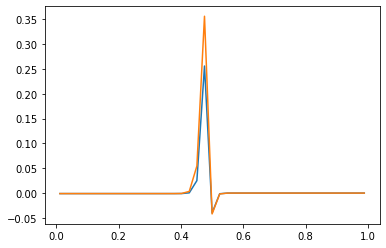

In [387]:
plt.plot(x_ax, theta[15]- theta_0, x_ax, theta[0] - theta_0)

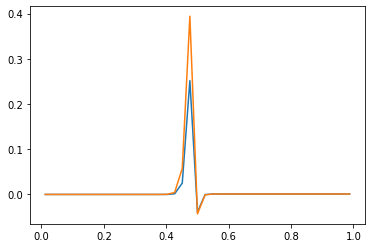

In [374]:
plt.plot(x_ax, theta[15]- theta_0, x_ax, theta[0] - theta_0)

In [375]:
theta[15]

array([4.29883443e-33, 4.29888581e-33, 5.53787540e-31, 6.80084826e-29,
       7.87896669e-27, 8.58043142e-25, 8.74834014e-23, 8.31214758e-21,
       7.32082210e-19, 5.93977036e-17, 4.40713946e-15, 2.96411710e-13,
       1.78772186e-11, 9.53873394e-10, 4.42438976e-08, 1.74222393e-06,
       5.62993523e-05, 1.41556791e-03, 2.51349506e-02, 2.52307389e-01,
       9.60064030e-01, 9.98700625e-01, 9.99969675e-01, 9.99999451e-01,
       9.99999992e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00])

In [23]:
middy = 0.5 * (lefty[:,1:] + lefty[:,:-1])

middy_y = 0.5 * (lefty[1:,:] + lefty[:-1,:])

print(np.shape(middy_y))
print(np.shape(np.array([lefty[0,:]])))

dxtry = np.vstack(((np.array([lefty[0,:]])), middy_y, (np.array([lefty[-1,:]]))))

#dxtry - y_grad

NameError: name 'lefty' is not defined

In [ ]:
x_grad

In [ ]:
def gradient_finder_2D(Nx, Ny, func):
    """
    Finds the d/dx and d/dy gradient fields of a 2D function/matrix
    NOTE : Identical to what numpy.gradient() does, however serves as
        a proof of concept for the C++ implementation
    NOTE : numpy.hstack() & .vstack() used for convenience, would be 
        replaced by simple loops in C++
    Inputs :
    ...
    ...
    ...
    """
    # calculate the x-derivative
        # cells in the middle have the average of the left- and right- derivatives
    x_difference = func[:, 1:]  - func[:, :-1] # defined as x_i+1,j - x_i,j
    dx_func = np.hstack((np.transpose(np.array([x_difference[:,0]])), 0.5 * (x_difference[:,1:] + x_difference[:,:-1]), np.transpose(np.array([x_difference[:,-1]]))))
    
    # calculate the y-derivative
        # cells in the middle have the average of the down- and up- derivatives
    y_difference = func[1:, :]  - func[:-1, :] # defined as x_i,j+1 - x_i,j
    dy_func = np.vstack(((np.array([y_difference[0,:]])), 0.5 * (y_difference[1:,:] + y_difference[:-1,:]), (np.array([y_difference[-1,:]]))))
    
    return dx_func, dy_func
